# Jacob Nagrocki and Andrew Hobden

Populating the interactive namespace from numpy and matplotlib


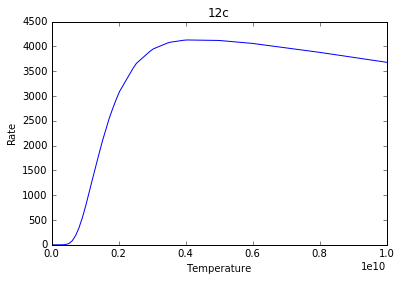

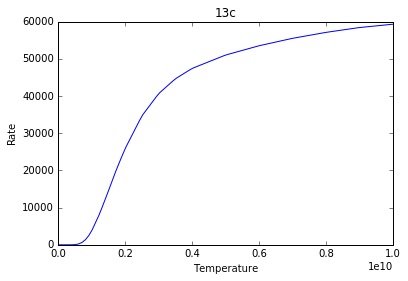

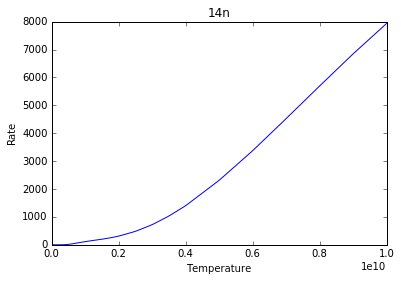

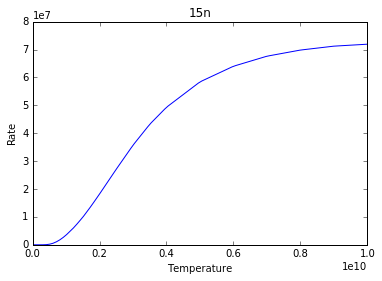

In [12]:
% pylab inline
def get_rates(element, temperatures, plot=False):
    """
    Reads reaction rates from NACRE and interpolates for a given temperature.
    
    Inputs:
        - element: One of "12c", "13c", "14n", "15n".
        - temperature: The temperature for which the rate is desired. Should be between (1e9 * 0.008) and (1e9 * 10.0).
    
    Output:
        - The rate.
    Note: Some elements support lower temperatures as well, see NACRE charts.
    """
    # Safety tests.
    assert len(element) == 3, "Element should be one of '12c', '13c', '14n', '15n'."
    assert int(element[:2]), "Element should be one of '12c', '13c', '14n', '15n'."
    assert len(temperatures) >= 1, "Include a temperature."
    # Open and handle the file.
    from glob import glob
    file = glob("elements/" + str(element) + "*.dat")[0]
    # Parse data.
    rows = [x.strip().split()[:2] for x in open(file).read().split("\n")][1:]
    temps,rates = zip(*[(float(temp) * 1e9, float(rate)) for temp, rate in rows])
    # Figure out interpolated rate.
    from scipy.interpolate import interp1d
    interpolated_function = interp1d(temps, rates)
    return interpolated_function(temperatures)
    
    
from numpy import linspace
from matplotlib.pyplot import plot
demo_temperatures = linspace(1e9 * 0.008, 1e9 * 10.0, num=100)
for element in ["12c", "13c", "14n", "15n"]:
    interpolated_rates = get_rates(element, demo_temperatures)
    title(element)
    xlabel("Temperature")
    ylabel("Rate")
    plot(demo_temperatures, interpolated_rates)
    show()

In [13]:
import numpy as np

In [14]:
#Setting up constants and initial values from the data sets

NA = 6.0221409*(10**23)
RHO = 100
T = 9*(10**7)

##Initial Mass Fractions calculations
XH1 = 7.1538567255*(10**-1)
XHe4 = 2.7025513111*(10**-1)
XC12 = 2.4825306734*(10**-3)
XC13 = 3.0083012115*(10**-5)
XN14 = 7.3396723494*(10**-4)
XN15 = 1.8049744286*(10**-6)

def massfrac(XH1, XHe4, XC12, XC13, XN14, XN15):
    NH1_0 = XH1/1*RHO*NA
    NHe4_0 = XHe4/4*RHO*NA
    NC12_0 = XC12/12*RHO*NA
    NC13_0 = XC13/13*RHO*NA
    NN14_0 = XN14/14*RHO*NA
    NN15_0 = XN15/15*RHO*NA
    why_not = [NH1_0,NHe4_0,NC12_0,NC13_0,NN14_0,NN15_0] #### y_0 joke around
    return why_not

steps=1000000
iteration_num = steps

#sigvX is the reaction rate for producing X
sigvC12 = 7.39E-06
sigvN13 = 7.36E-06
sigvN14 = 3.52E-05
sigvO15 = 2.36E-07

In [15]:
##Let's chunk all the code above into arrays to make things easier for scipy integrate

why_not = massfrac(XH1, XHe4, XC12, XC13, XN14, XN15) #### y_0 joke around
rates = [7.39E-06,7.36E-06,3.52E-05,2.36E-07] ##initialize to some nice vals

In [16]:
def reactionratetemp(temp):
    '''
        inputs:
        -------
        temp: a one element array with temp between (1e9 * 0.008) and (1e9 * 10.0)
        
        outputs:
        --------
        none. but changes the value of reaction rates.
        Names seem to be mixed up, but this is because my naming was for the reaction rate of producing X,
        and Andrew's naming was for the begginning of the filename, which was for the reaction rate of consuming X.
    '''
    rates = [0]*4
    #sigvC12
    rates[0] = get_rates('15n', temp)[0]
    #sigvN13 
    rates[1] = get_rates('12c', temp)[0]
    #sigvN14
    rates[2] = get_rates('13c', temp)[0]
    #sigvO15 
    rates[3] = get_rates('14n', temp)[0]
    return rates

In [17]:
def f_rhs(y,t,rates):
    """
    inputs: 
    -------
            y, a 6 element array like this: [NH1_0,NHe4_0,NC12_0,NC13_0,NN14_0,NN15_0]
    
            t, scipy deals with this, when odeint is given tlist
            
            rates, a 4 element array of rates like this: [sigvC12, sigvN13, sigvN14, sigvO15]
            
    outputs:
    --------
            the next set of derivatives in a 6 element array

    """
    dNH1dt = -y[3]*y[0]*rates[2]/NA - y[5]*y[0]*rates[0]/NA - y[4]*y[0]*rates[3]/NA - y[2]*y[0]*rates[1]/NA
    dNHe4dt = y[5]*y[0]*rates[0]/NA
    dNC12dt = y[5]*y[0]*rates[0]/NA - y[2]*y[0]*rates[1]/NA
    dNC13dt = y[2]*y[0]*rates[1]/NA - y[3]*y[0]*rates[2]/NA
    dNN14dt = y[3]*y[0]*rates[2]/NA - y[4]*y[0]*rates[3]/NA
    dNN15dt = y[4]*y[0]*rates[3]/NA - y[5]*y[0]*rates[0]/NA
    yi = [dNH1dt, dNHe4dt, dNC12dt, dNC13dt, dNN14dt, dNN15dt]
    return yi

### Below are three graphs which demonstrate 3 different temperature values, and the time ranges on which H1 is consumed

In [18]:
from scipy import integrate
import matplotlib.pyplot as plt

In [19]:
Temp = [3*(10**8)]
rates = reactionratetemp(Temp)
tlist=np.linspace(0.01,10**3.5,steps)  

Nlist=integrate.odeint(f_rhs,why_not,tlist,args=(rates,))
Nlist = Nlist.transpose()

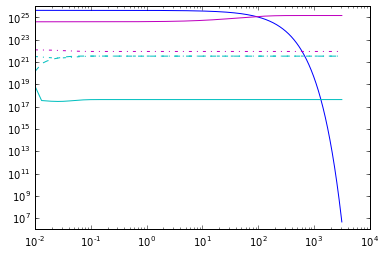

In [11]:
plt.plot(tlist,Nlist[0],'b-',tlist, Nlist[1], 'm-',tlist, Nlist[2], 'm-.',tlist, Nlist[3], 'c--',tlist, Nlist[4], 'c-.',tlist, Nlist[5], 'c-')
plt.yscale('log')
plt.xscale('log')

In [20]:
Temp = [3*(10**7)]
rates = reactionratetemp(Temp)
tlist=np.linspace(0.01,10**15,steps)  

Nlist=integrate.odeint(f_rhs,why_not,tlist,args=(rates,))
Nlist = Nlist.transpose()

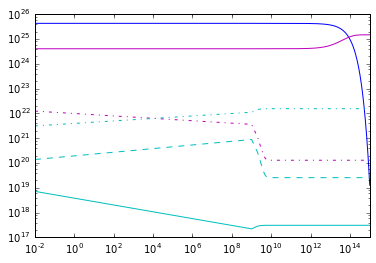

In [13]:
plt.plot(tlist,Nlist[0],'b-',tlist, Nlist[1], 'm-',tlist, Nlist[2], 'm-.',tlist, Nlist[3], 'c--',tlist, Nlist[4], 'c-.',tlist, Nlist[5], 'c-')
plt.yscale('log')
plt.xscale('log')

In [21]:
Temp = [3*(10**9)]
rates = reactionratetemp(Temp)
tlist=np.linspace(0.01,10**(-0.3),steps)  

Nlist=integrate.odeint(f_rhs,why_not,tlist,args=(rates,))
Nlist = Nlist.transpose()

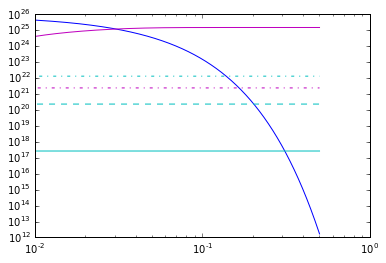

In [15]:
plt.plot(tlist,Nlist[0],'b-',tlist, Nlist[1], 'm-',tlist, Nlist[2], 'm-.',tlist, Nlist[3], 'c--',tlist, Nlist[4], 'c-.',tlist, Nlist[5], 'c-')
plt.yscale('log')
plt.xscale('log')

In [23]:
##### Most of the below code is straight from the star explore notebook. Thanks Falk!

import star_utils as su

In [24]:
# introduce code units:                                                               
# one unit of density: g_cu * cm_cu**-3 = 0.1691355                                   
# one length unit:  1R_sun = 6.955e+10 cm                                             
# one unit of mass: 1M_sun = 1.9891e+33 g                                             
# one unit of time: 1yr    = 3.14e7s    

L_cu = su.rsun_cm    # length in code unit                                            
cm_cu = 1./L_cu
M_cu = su.msun_g
g_cu = 1./M_cu
T_cu = 3.14e7
s_cu = 1/T_cu

# G in units of 'cm^3 g^-1 s^-2'  
G_cu = su.grav_const * cm_cu**3 * g_cu**-1 * s_cu**-2
# one unit of pressure: [cgs: g cm^-1 s^-2] -> Msun Rsun^-1 yr^-2                     

In [25]:
#Piling code below that I am using to get the WENDI data
'''
import mesa as ms
%pylab nbagg

nugrid_data_dir='/home/nugrid/CADC/NuGrid'
m2_dir=nugrid_data_dir+'/data/teaching/mesa/m2.00z2.0e-2/LOGS'
m20_dir=nugrid_data_dir+'/data/teaching/mesa/m20.0z2.0e-2/LOGS'

s2=ms.star_log(m2_dir)
s20=ms.star_log(m20_dir)

# what colums are available in this history data instance?
s2.cols

ifig=2; figure(ifig)     # start new figure
s2.plot('model_number','center_h1')
'''
#The graph plotted by the above line makes it clear Hydrogen begins burning rapidly at about model 920. Let's take model
#915 for integration.
'''
# after you found a profile you are interested in, e.g. a fully 
# convective pre-main sequence model you may create a profile instance
# for a model number
p2=ms.mesa_profile(m2_dir,910)

# and again you may ask what columns are available
p2.cols


'''

'\n# after you found a profile you are interested in, e.g. a fully \n# convective pre-main sequence model you may create a profile instance\n# for a model number\np2=ms.mesa_profile(m2_dir,910)\n\n# and again you may ask what columns are available\np2.cols\n\n\n'

<img src="A4Plot1.png">

In [26]:
# Changing these values based on s2 model 915:

#p2.get('log_Rho') = 1.8092148607980052
#since log_10 Rho = 1.8092148607980052, 10**1.8092148607980052 = Rho ??
rho_c = 10**(1.8092148607980052)    # in cgs                                             
rho_c = rho_c * g_cu * cm_cu**-3 # cu 

#p2.get('pressure')[-1]
P_c = 1.8322767595253354e+17         # in cgs                                             
P_c = P_c * g_cu * cm_cu**-1 * s_cu**-2 # cu                                          
print(rho_c, P_c)

# p2.get('radius')[-1],p2.get('mass')[-1]                                             
r_c = 0.0015055359898714213   # in L_cu = R_sun                                        
m_c = 1.5613084998196831e-07 # in M_cu = M_sun                                        

10.900580999401965 6316709232.833556


In [27]:
# EOS:                                                                                
gamma_ad = 5./3.
K_ad = P_c/(rho_c**gamma_ad)
K    = K_ad
print(K)

def rho(p):   # polytropic EOS                                                        
        return (p/K)**(1./gamma_ad)

117871318.67035455


In [28]:
# unit tester EOS:                                                                    
print(rho(P_c), rho_c)


10.900580999401965 10.900580999401965


In [29]:
# RHS of system of ODEs                                                               
def f_rhs_2(y,r):
    dm_dr = 4.*pi*(r**2)*rho(y[1])
    dp_dr = -rho(y[1])*G_cu*y[0]/(r**2)
    return [dm_dr,dp_dr]

In [30]:
# initial conditions                                                                  
V0  = 4./3*pi*r_c**3
m_0 = rho_c*V0
print(m_0,m_c)

1.558158671869597e-07 1.561308499819683e-07


In [31]:
from scipy import integrate
# integrate.odeint?


In [32]:
y0=[m_0,P_c]
steps = 1000
#we want to integrate from the radius at the core up to the 20% mass radius, which is ~0.23 solar radius
rlist = np.linspace(r_c,0.23,steps)

In [33]:
Y=integrate.odeint(f_rhs_2,y0,rlist)

In [34]:
m_poly = Y.transpose()[0]
p_poly = Y.transpose()[1]

"\nifig=8; figure(ifig)     # start new figure\np2.plot('mass','pressure')\n"

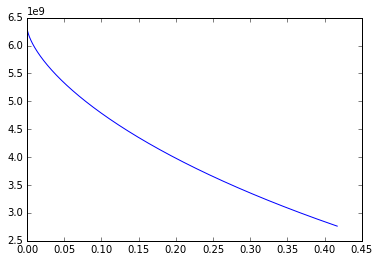

In [35]:
plt.plot(m_poly,p_poly,'b-')
#ylab = 'Pressure/[Msun Rsun^-1 yr^-2]'
#xlab = 'Mass/[Msun]'

#This plot agrees very nicely with the plot achieved by WENDI, just with different units.
'''
ifig=8; figure(ifig)     # start new figure
p2.plot('mass','pressure')
'''

<img src="A4Plot2.png">

In [36]:
def T_ideal_gas(rho,P,mu=1.):
    '''
    ideal gas EOS for astronomy
        
    P = (R/mu) * rho * T
    so T = (P/rho)*(mu/R)
    R: gas constant
    
    parameters
    ----------
    mu : float
        mean molecular weight [in units of the atomic mass unit]
    rho : float
        density [in cgs units]
    P : float
        pressure [in cgs]
    '''

    R = 83144621.4563013 # cgs units [ g * cm^2 * s^-2 * K^-1 * mol^-1]
    R = R * g_cu * cm_cu**2 * s_cu**-2 
    T_ideal = (P/rho)*(mu/R)
    return T_ideal ###Value in Kelvin

In [37]:
#mu data at different radii in the p2 model
#basically constant at 0.622 in the range we need it
mu_p2 = 0.622

In [38]:
TListp2 = [0]*len(p_poly)
for i in range(len(p_poly)):
    TListp2[i] = T_ideal_gas(rho(p_poly[i]), p_poly[i], mu_p2)


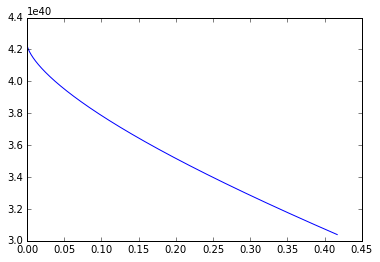

In [39]:
plot(m_poly, TListp2, 'b-')
#Again, very nice correlation with the WENDI data!
#The scale is off by 1e33 so I think something funny is happening with the code units....
#But the value still decreases by a ratio of about 3/4 so I think this demonstrates the right things

<img src="A4Plot3.png">

### Now let's do the same thing for the 20M star

In [40]:
#Piling code below that I am using to get the WENDI data
'''
# what colums are available in this history data instance?
s2.cols

ifig=9; figure(ifig)     # start new figure
s20.plot('model_number','center_h1')
'''
#The graph plotted by the above line makes it clear Hydrogen begins burning rapidly at about model 1000.
'''
# after you found a profile you are interested in, e.g. a fully 
# convective pre-main sequence model you may create a profile instance
# for a model number
p20=ms.mesa_profile(m20_dir,1000)

# and again you may ask what columns are available
p20.cols

ifig=11; figure(ifig)     # start new figure
p20.plot('radius','mass')

From this figure, we see that 20% of 20 solar mass (4 solar mass) is achieved at 1.25 solar radii.
'''

'''mass vs radius'''

'mass vs radius'

<img src="A4Plot4.png">

In [41]:
# Changing these values based on s20 model 1000:

#p20.get('log_Rho') = 0.589280414575
#since log_10 Rho = 0.589280414575 => 10**0.589280414575 = Rho ??
rho_c_20 = 10**(0.589280414575)    # in cgs                                             
rho_c_20 = rho_c_20 * g_cu * cm_cu**-3 # cu 

#p20.get('pressure')[-1]
P_c_20 = 2.04927713593e+16        # in cgs                                             
P_c_20 = P_c_20 * g_cu * cm_cu**-1 * s_cu**-2 # cu                                          
print(rho_c, P_c)

# p20.get('radius')[-1],p20.get('mass')[-1]                                             
r_c_20 = 0.00827569458777   # in L_cu = R_sun                                        
m_c_20 = 1.56276694541e-06 # in M_cu = M_sun                      

10.900580999401965 6316709232.833556


In [42]:
# EOS:                                                                                
gamma_ad = 5./3.
K_ad_20 = P_c_20/(rho_c_20**gamma_ad)
K_20    = K_ad_20
print(K_20)

def rho(p):   # polytropic EOS                                                        
        return (p/K_20)**(1./gamma_ad)

1423121044.0902739


In [43]:
# unit tester EOS:                                                                    
print(rho(P_c_20), rho_c_20) ##Holy Precision Batman!!

0.6569241082077224 0.6569241082077224


In [44]:
# initial conditions                                                                  
V0_20  = 4./3*pi*r_c_20**3
m_0_20 = rho_c_20*V0_20
print(m_0_20,m_c_20)

1.5596141751448826e-06 1.56276694541e-06


In [45]:
y0_20=[m_0_20,P_c_20]
steps = 1000
#we want to integrate from the radius at the core up to the 20% mass radius, which is ~1.25 solar radius
rlist_20 = np.linspace(r_c_20,1.25,steps)

In [46]:
Y=integrate.odeint(f_rhs_2,y0_20,rlist_20)

In [47]:
m_poly20 = Y.transpose()[0]
p_poly20 = Y.transpose()[1]

"\nifig=13; figure(ifig)     # start new figure\np20.plot('mass','pressure')\n"

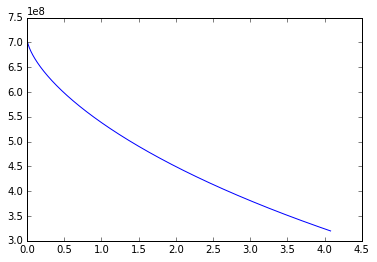

In [48]:
plt.plot(m_poly20,p_poly20,'b-')
#ylab = 'Pressure/[Msun Rsun^-1 yr^-2]'
#xlab = 'Mass/[Msun]'

#This plot agrees very nicely with the plot achieved by WENDI, just with different units.
'''
ifig=13; figure(ifig)     # start new figure
p20.plot('mass','pressure')
'''

<img src="A4Plot7.png">

In [49]:
#mu data at different radii in the p20 model
#basically constant at 0.617 in the range we need it
mu_p20 = 0.617

In [50]:
TListp20 = [0]*len(p_poly20)
for i in range(len(p_poly20)):
    TListp20[i] = T_ideal_gas(rho(p_poly20[i]), p_poly20[i], mu_p20)


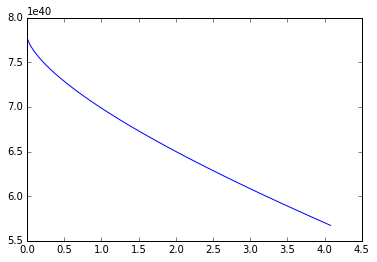

In [51]:
plot(m_poly20, TListp20, 'b-')
#Again, very nice correlation with the WENDI data!
#The scale is off by 1e33 so I think something funny is happening with the code units....
#But the value still decreases by a ratio of about 3/4 so I think this demonstrates the right things

<img src="A4Plot6.png">

We have shown that the P-Rho profiles are the same in our models and the WENDI models.

We have also shown that the Temperature profiles of our computed model, and the WENDI models follow the same trends. The units are different but the change in scale is the same.


In [52]:
#Let's find some more relative abundance data for the isotopes, but now using the temperatures above.
#There seems to be only data for H1, He4, C12 and N14, but we will just leave the initial conditions for C13 and N15 at zero.



In [53]:
##Initial Mass Fractions calculations
XH1_s2 = 6.957*(10**-1)
XHe4_s2 = 2.837*(10**-1)
XC12_s2 = 2.9862*(10**-5)
XC13_s2 = 0
XN14_s2 = 5.1272*(10**-3)
XN15_s2 = 0

why_not = massfrac(XH1_s2, XHe4_s2, XC12_s2, XC13_s2, XN14_s2, XN15_s2)
print(why_not)
#At the core, the temp is
Temp = [2.1*(10**7)]
rates = reactionratetemp(Temp)

#It takes about 9*10**8 years for almost all of the center H1 to burn from the S2 star.
#However, nothing happens until about the 10**15, or 10**16 time magnitude
tlist_s2 = np.linspace(0.01,9*10**17.5,steps)  

Nlist=integrate.odeint(f_rhs,why_not,tlist_s2,args=(rates,))
Nlist = Nlist.transpose()


[4.189603424129999e+25, 4.2712034333249996e+24, 1.4986097629650004e+20, 0.0, 2.2054800587485715e+22, 0.0]


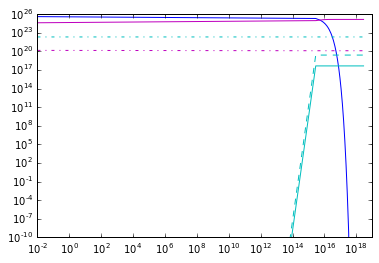

In [47]:
plt.plot(tlist_s2,Nlist[0],'b-',tlist_s2, Nlist[1], 'm-',tlist_s2, Nlist[2], 'm-.',tlist_s2, Nlist[3], 'c--',tlist_s2, Nlist[4], 'c-.',tlist_s2, Nlist[5], 'c-')
plt.yscale('log')
plt.xscale('log')

The WENDI data suggested that the star should burn its core hydrogen in 10^8 years, but our data shows that nothing happens until a time scale of 10^16.

In [54]:
##Initial Mass Fractions calculations
XH1_s20 = 7.059*(10**-1)
XHe4_s20 = 2.736*(10**-1)
XC12_s20 = 2.279*(10**-4)
XC13_s20 = 7.723*(10**-5)
XN14_s20 = 4.776*(10**-3)
XN15_s20 = 9.736*(10**-8)

why_not = massfrac(XH1_s20, XHe4_s20, XC12_s20, XC13_s20, XN14_s20, XN15_s20)
print(why_not)
#At the core, the temp is
Temp = [3.28*(10**7)]
rates = reactionratetemp(Temp)

#It takes about 8.5*10**7 years for almost all of the center H1 to burn from the S2 star. (from WENDI)
#However, nothing happens until about the 10**12 time magnitude
tlist_s20 = np.linspace(0.01,9*10**14,steps)  

Nlist=integrate.odeint(f_rhs,why_not,tlist_s20,args=(rates,))
Nlist = Nlist.transpose()

[4.25102926131e+25, 4.1191443755999993e+24, 1.1437049259249998e+21, 3.577614936207692e+20, 2.054410352742857e+22, 3.90877092016e+17]


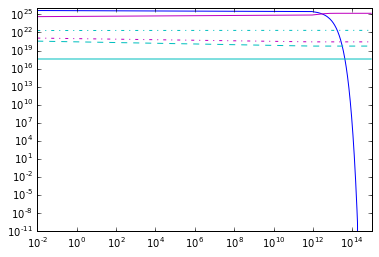

In [49]:
plt.plot(tlist_s20,Nlist[0],'b-',tlist_s20, Nlist[1], 'm-',tlist_s20, Nlist[2], 'm-.',tlist_s20, Nlist[3], 'c--',tlist_s20, Nlist[4], 'c-.',tlist_s20, Nlist[5], 'c-')
plt.yscale('log')
plt.xscale('log')